# Final Project for COGS118A, this is meant to find and identify russian 'troll' tweets.

Group members :
- Gael Van der Lee
- Alex Labranche

In [1]:
import sklearn as sk
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import re
import random
import string as st
from gensim.models import word2vec
from collections import Counter
from itertools import chain

In [2]:
# For display purposes
#from IPython.display import display
#pd.options.display.max_columns = 10
all_start = time.time()

# Data gathering and cleaning

### Loading and cleaning

In [3]:
# Load the 3 datasets
troll_users = pd.read_csv('Tweets/Trolls/users.csv')
troll_tweets = pd.read_csv('Tweets/Trolls/tweets.csv')
normal_tweets = pd.read_csv('Tweets/Normal/dashboard_x_usa_x_filter_nativeretweets.csv')

In [4]:
print('Columns of each dataframe at import :\n\nTroll users : {}\n\nTroll tweets : {}\n\nNormal tweets : {}'
      .format(troll_users.columns.values, troll_tweets.columns.values, normal_tweets.columns.values))

Columns of each dataframe at import :

Troll users : ['id' 'location' 'name' 'followers_count' 'statuses_count' 'time_zone'
 'verified' 'lang' 'screen_name' 'description' 'created_at'
 'favourites_count' 'friends_count' 'listed_count']

Troll tweets : ['user_id' 'user_key' 'created_at' 'created_str' 'retweet_count'
 'retweeted' 'favorite_count' 'text' 'tweet_id' 'source' 'hashtags'
 'expanded_urls' 'posted' 'mentions' 'retweeted_status_id'
 'in_reply_to_status_id']

Normal tweets : ['Tweet Id' 'Date' 'Hour' 'User Name' 'Nickname' 'Bio' 'Tweet content'
 'Favs' 'RTs' 'Latitude' 'Longitude' 'Country' 'Place (as appears on Bio)'
 'Profile picture' 'Followers' 'Following' 'Listed'
 'Tweet language (ISO 639-1)' 'Tweet Url']


In [5]:
# Make Nicknames consistent
troll_users['screen_name'] = troll_users['screen_name'].str.lower()

# Drop the irrelevant data
users_to_drop = ['statuses_count', 'time_zone', 'verified', 'favourites_count']
tweets_to_drop = ['created_at', 'tweet_id', 'source', 'posted', 'retweeted_status_id', 'retweeted', 'in_reply_to_status_id']
normal_to_drop = ['Tweet Id', 'Latitude', 'Longitude', 'Country', 'Profile picture', 'Tweet Url']
troll_users = troll_users.drop(users_to_drop, axis=1)
troll_tweets = troll_tweets.drop(tweets_to_drop, axis=1)
normal_tweets = normal_tweets.drop(normal_to_drop, axis=1)

In [6]:
users_new_cols = {'id': 'User Id', 'location': 'Location', 'name': 'User Name', 
                  'followers_count': 'Followers', 'lang': 'Language', 'screen_name': 'Nickname',
                  'description': 'Bio', 'created_at': 'Account creation date', 
                  'friends_count': 'Following', 'listed_count': 'Listed'}
tweets_new_cols = {'user_id': 'User Id', 'user_key': 'Nickname', 'created_str': 'Tweet date',
                   'retweet_count': 'Retweets', 'favorite_count': 'Favorites', 'text': 'Tweet',
                   'hashtags': 'Hashtags', 'expanded_urls': 'URLs', 'mentions': 'Mentions'}
normal_new_cols = {'Tweet content': 'Tweet', 'Favs': 'Favorites', 'RTs': 'Retweets', 
                   'Place (as appears on Bio)': 'Location', 'Tweet language (ISO 639-1)': 'Language'}

troll_users = troll_users.rename(columns=users_new_cols)
troll_tweets = troll_tweets.rename(columns=tweets_new_cols)
normal_tweets = normal_tweets.rename(columns=normal_new_cols)

# Make times formats the same
normal_tweets['Tweet date'] = normal_tweets['Date'] + ' ' + normal_tweets['Hour']
normal_tweets = normal_tweets.drop(['Date', 'Hour'], axis=1)

# Helps with merging
troll_users = troll_users.drop(['User Id', 'Account creation date'], axis=1)
troll_tweets = troll_tweets.drop('User Id', axis=1)

In [7]:
print('Columns of each dataframe after cleaning :\n\nTroll users : {}\n\nTroll tweets : {}\n\nNormal tweets : {}'
      .format(troll_users.columns.values, troll_tweets.columns.values, normal_tweets.columns.values))

Columns of each dataframe after cleaning :

Troll users : ['Location' 'User Name' 'Followers' 'Language' 'Nickname' 'Bio'
 'Following' 'Listed']

Troll tweets : ['Nickname' 'Tweet date' 'Retweets' 'Favorites' 'Tweet' 'Hashtags' 'URLs'
 'Mentions']

Normal tweets : ['User Name' 'Nickname' 'Bio' 'Tweet' 'Favorites' 'Retweets' 'Location'
 'Followers' 'Following' 'Listed' 'Language' 'Tweet date']


### Labeling and merging the datasets

In [8]:
# Merge the troll datasets
trolls = pd.merge(left=troll_tweets, right=troll_users)

In [9]:
trolls.iloc[:2, :]

,Nickname,Tweet date,Retweets,Favorites,Tweet,Hashtags,URLs,Mentions,Location,User Name,Followers,Language,Bio,Following,Listed
0,kathiemrr,2017-02-27 14:54:00,NaN,NaN,#ThingsDoneByMistake kissing auntie in the lips,"[""ThingsDoneByMistake""]",[],[],Atlanta,Kathie,2970.0,en,"Imperfection is beauty, madness is genius and ...",3157.0,22.0
1,kathiemrr,2016-11-28 16:17:36,NaN,NaN,RT @jadedsweetangel: #ToDoListBeforeChristmas ...,"[""ToDoListBeforeChristmas""]",[],[],Atlanta,Kathie,2970.0,en,"Imperfection is beauty, madness is genius and ...",3157.0,22.0


In [10]:
normal_tweets.iloc[:2, :]

,User Name,Nickname,Bio,Tweet,Favorites,Retweets,Location,Followers,Following,Listed,Language,Tweet date
0,Bill Schulhoff,BillSchulhoff,"Husband,Dad,GrandDad,Ordained Minister, Umpire...","Wind 3.2 mph NNE. Barometer 30.20 in, Rising s...",NaN,NaN,"East Patchogue, NY",386.0,705.0,24.0,en,2016-04-16 12:44
1,Daniele Polis,danipolis,"Viagens, geek, moda, batons laranja, cabelos c...",Pausa pro café antes de embarcar no próximo vô...,NaN,NaN,"Grapevine, TX",812.0,647.0,16.0,pt,2016-04-16 12:44


In [11]:
# Put labels
trolls['y'] = pd.Series([1 for x in range(len(trolls))], index=trolls.index)
normal_tweets['y'] = pd.Series([0 for x in range(len(normal_tweets))], index=normal_tweets.index)

In [12]:
# Merge normal and troll data 
tweets = trolls.append(normal_tweets, ignore_index=True)
print(tweets.shape)

(408271, 16)


In [13]:
# Rows to display
rows = [1, 100000, 300000]
#rows = [random.randint(0, len(tweets)) for i in range(4)]

In [14]:
tweets.iloc[rows, :]

,Bio,Favorites,Followers,Following,Hashtags,Language,Listed,Location,Mentions,Nickname,Retweets,Tweet,Tweet date,URLs,User Name,y
1,"Imperfection is beauty, madness is genius and ...",NaN,2970.0,3157.0,"[""ToDoListBeforeChristmas""]",en,22.0,Atlanta,[],kathiemrr,NaN,RT @jadedsweetangel: #ToDoListBeforeChristmas ...,2016-11-28 16:17:36,[],Kathie,1
100000,"Lover of Life and Israel, Jesus and Country mu...",NaN,338.0,429.0,[],en,6.0,USA,[],hollandpatrickk,NaN,RT @PrisonPlanet: Trump proves once again that...,2017-01-02 21:46:18,[],Patrick,1
300000,Segment Producer for Noticieros - Telemundo 51...,NaN,810.0,1028.0,NaN,es,16.0,"Miami, FL",NaN,DanielTeleMundo,NaN,Recording the program Rostros for Telemundo 51...,2016-04-15 17:17,NaN,DanielTelemundo,0


### Extracting hashtags and mentions

In [15]:
def extract_hashtag(string):
    htags = []
    string = str(string)
    for word in string.split():
        if word[0] == '#':
            htags.append(word[1:])
    splits= []
    # Puts space before capital letters and numbers
    for h in htags:
        splits.append(re.sub(r"([A-Z0-9])", r" \1", h)[1:])
    return splits

def extract_mentions(string):
    men = []
    string = str(string)
    for word in string.split():
        if word[0] == '@':
            if word[-1] == ':':
                men.append(word[1:-1])
            else:
                men.append(word[1:])
    return men

# Not implemented yet, takes way too long to run
def extract_links(string):
    links = []
    string = str(string)
    for word in string.split():
        if word[:4] == 'http':
            try:
                link = urlopen(word).geturl()  # This waits for the website (up to 1 sec)
                links.append(link)
            except:
                pass
    return links

def extract_website(data):
    data = str(data)
    websites = []
    for string in data.split():
        start = string.find('//') + 2
        if string[start:start+3] == 'www':
            start = start+4
        if start > 1:
            end = string[start:].find('/') + start
            websites.append(string[start:end])
    return websites

In [16]:
tweets['Websites'] = tweets['URLs'].apply(extract_website)
print('Sample of extracted websites : ')
tweets['Websites'][tweets['Websites'].apply(lambda x: len(x) > 0)][:5]

Sample of extracted websites : 


330       [twitter.com]
655       [newsmax.com]
696     [wikileaks.org]
1306      [twitter.com]
1504      [twitter.com]
Name: Websites, dtype: object

In [17]:
tweets['Hashtags'] = tweets['Tweet'].apply(extract_hashtag)
tweets['Mentions'] = tweets['Tweet'].apply(extract_mentions)

### Cleaning tweets

In [18]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

punc = (st.punctuation.replace('@', '').replace('#', '')) + '"' + "'" + '”' + '“' + '‘'
translator = str.maketrans('', '', punc)

def clean(string):
    string = str(string).lower()
    string = string.translate(translator)
    string = string.split()
    to_remove = []
    for word in string:
        if word[0] == '#' or word[0] == '@' or word == 'rt' or word[:4] == 'http' or word[0].isnumeric():
            to_remove.append(word)
    for word in to_remove:
        string.remove(word)
    text = emoji_pattern.sub(r'', ' '.join(string))
    text = re.sub("[^a-zA-Z ]","", text)
    return text

In [19]:
# cleans up and keeps only the text in each tweet
tweets['Tweet'] = tweets['Tweet'].apply(clean)

In [20]:
tweets.iloc[rows, :]

,Bio,Favorites,Followers,Following,Hashtags,Language,Listed,Location,Mentions,Nickname,Retweets,Tweet,Tweet date,URLs,User Name,y,Websites
1,"Imperfection is beauty, madness is genius and ...",NaN,2970.0,3157.0,[To Do List Before Christmas],en,22.0,Atlanta,[jadedsweetangel],kathiemrr,NaN,get on the naughty list,2016-11-28 16:17:36,[],Kathie,1,[]
100000,"Lover of Life and Israel, Jesus and Country mu...",NaN,338.0,429.0,[],en,6.0,USA,[PrisonPlanet],hollandpatrickk,NaN,trump proves once again that he cares about bl...,2017-01-02 21:46:18,[],Patrick,1,[]
300000,Segment Producer for Noticieros - Telemundo 51...,NaN,810.0,1028.0,[],es,16.0,"Miami, FL",[],DanielTeleMundo,NaN,recording the program rostros for telemundo at...,2016-04-15 17:17,NaN,DanielTelemundo,0,[]


### Replace Missing Values

In [21]:
print(tweets.shape)
#replace NaNs with 0s where appropriate
tweets['Retweets'].fillna(0,inplace=True)
tweets['Favorites'].fillna(0,inplace=True)
tweets['URLs'].fillna(0,inplace=True)
#replace NaNs with empty list where appropriate (URLs)

# Drop nans
tweets = tweets.dropna(axis=0)
print(tweets.shape)

(408271, 17)
(335381, 17)


In [22]:
tweets.iloc[rows, :]

,Bio,Favorites,Followers,Following,Hashtags,Language,Listed,Location,Mentions,Nickname,Retweets,Tweet,Tweet date,URLs,User Name,y,Websites
1,"Imperfection is beauty, madness is genius and ...",0.0,2970.0,3157.0,[To Do List Before Christmas],en,22.0,Atlanta,[jadedsweetangel],kathiemrr,0.0,get on the naughty list,2016-11-28 16:17:36,[],Kathie,1,[]
123464,Life is a beautiful struggle. Seek enlightenme...,0.0,914.0,847.0,[],en,23.0,"USA, Atlanta",[Superstar_floss],mrclydepratt,0.0,feel this way feat fred the godson rysovalid a...,2017-04-10 22:03:54,[],Clyde Pratt,1,[]
368504,Follow this account for geo-targeted Hospitali...,0.0,479.0,295.0,"[Hospitality, Job, L Y N W O O D,, Veterans, J...",en,85.0,"Lynwood, CA",[],tmj_lax_hrta,0.0,alert shift supervisor us starbucks atlantic a...,2016-04-14 20:29,0,TMJ-LAX HRTA Jobs,0,[]


In [23]:
# Suffle for training and testing
tweets = tweets.sample(frac=1).reset_index(drop=True)

# Different methods for NLP : 1 hot encoding for K Nearsest Neighbors and SVM 

In [24]:
#things that would be good to do
#lemmatization
#removing stopwords

#this is for the paper, we won't do this for the project

In [25]:
def get_best_model(model, X, y, param_dict, crossval):
    start = time.time()
    gs = sk.model_selection.GridSearchCV(model, param_dict, cv=crossval, refit = True)
    gs.fit(X, y)
    print('Gridsearch took {:.3f} secs to run on {} samples'.format(time.time() - start, len(X)))
    best_acc = gs.best_score_
    print('Best accuracy is {}\nBest estimator :\n{}'.format(best_acc, gs.best_estimator_))
    return gs, best_acc

In [26]:
def train_test_model(model, X_train, y_train, X_test, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print('Training took {:.3f} seconds'.format(time.time()-start))
    print('Using {} samples, this model got accuracy {}'.format(len(X_train) + len(X_test), acc))
    return model, acc

### Set up data for 1 hot encoding

In [27]:
# Not used for now

# replace language with one-hot encoded form
#one_hot_lang = pd.get_dummies(tweets['Language'])
# number of mentions
#num_mentions = tweets['Mentions'].apply(lambda x: len(x))

# Use only english for now
tweets = tweets[tweets['Language'] == 'en']

In [28]:
def create_1_hot(num_rows, cols):
    # For now use only tweets
    result = tweets[cols][:num_rows].copy()
    #create 1 hot dataframe :
    start = time.time()
    result = result.str.get_dummies(sep=' ')
    print('Took {:.3f} secs to create 1 hot matrix with dimensions {}'.format(time.time()-start, result.shape)) # 170 sec for 10,000
    columns_names = result.columns.values.tolist()
    return result.as_matrix(), columns_names

In [29]:
def make_matrices(size_gs, size_best, encoding):
    # Sets up matrics for girdsearch and for the best estimator
    if encoding == '1hot':
        matrix_gs, cols_gs = create_1_hot(size_gs, 'Tweet')
        matrix_best, cols_best = create_1_hot(size_best, 'Tweet')
    elif encoding == 'w2v_tfidf':
        matrix_gs = create_word2vec(size_gs, 'Tweet', 'tfidf')
        matrix_best = create_word2vec(size_best, 'Tweet', 'tfidf')
    elif encoding == 'w2v_avg':
        matrix_gs = create_word2vec(size_gs, 'Tweet', 'avg')
        matrix_best = create_word2vec(size_best, 'Tweet', 'avg')
    else:
        raise ValueError('Input needs to be "1hot", "tfidf" or "avg"')
    y_gs = tweets['y'][:size_gs].as_matrix()
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    matrix_best, tweets['y'][:size_best].as_matrix(), test_size=0.2, random_state=0)
    if encoding == '1hot':
        return matrix_gs, y_gs, cols_gs, X_train, y_train, X_test, y_test, cols_best
    return matrix_gs, y_gs, X_train, y_train, X_test, y_test

In [30]:
size_grid, size_best_est = 500, 10000
crossval = 3
gridsearch_matrix_1_hot, y, columns_gs_1_hot, X_train, y_train, X_test, y_test, columns_1_hot = make_matrices(size_grid, size_best_est, '1hot')

Took 1.157 secs to create 1 hot matrix with dimensions (500, 2113)
Took 168.046 secs to create 1 hot matrix with dimensions (10000, 15097)


## KNN

### Setting up

In [31]:
knn_1h = sk.neighbors.KNeighborsClassifier(n_jobs=-1)

# Number of nearest neighbors to consider
n_neighbors_list = [i+1 for i in range(6)]

# Weighting of neighbors, whether they all get an equal vote or are weighted by distance
weights_list = ['uniform','distance']
param_dict_1h_KNN = {'n_neighbors':n_neighbors_list,'weights':weights_list}

### Run Gridsearch

In [32]:
knn_1h_gs, knn_1h_gs_best_acc = get_best_model(knn_1h, gridsearch_matrix_1_hot, y, param_dict_1h_KNN, crossval)

Gridsearch took 12.382 secs to run on 500 samples
Best accuracy is 0.654
Best estimator :
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')


### Train and test best estimator

In [33]:
best_knn_1h, best_knn_1h_acc = train_test_model(knn_1h_gs.best_estimator_, X_train, y_train, X_test, y_test)

Training took 163.702 seconds
Using 10000 samples, this model got accuracy 0.7145


## SVM : SVC

### Setting up

In [34]:
# Set up SVM
svm_1h = sk.svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                       probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                       max_iter=-1, decision_function_shape='ovr', random_state=None)

# Set up Gridsearch
C_list =[10**(1-i) for i in range(4)]
kernel_list =['linear','rbf','sigmoid','poly']
param_dict_1h_SVM = {'C':C_list, 'kernel':kernel_list}

### Run Gridsearch

In [35]:
svm_1h_gs, svm_1h_gs_best_acc = get_best_model(svm_1h, gridsearch_matrix_1_hot, y, param_dict_1h_SVM, crossval)

Gridsearch took 32.686 secs to run on 500 samples
Best accuracy is 0.72
Best estimator :
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Train and test best estimator

In [36]:
best_svm_1h, best_svm_1h_acc = train_test_model(svm_1h_gs.best_estimator_, X_train, y_train, X_test, y_test)

Training took 621.660 seconds
Using 10000 samples, this model got accuracy 0.8455


## SVM : LinearSVC

### Setting up

In [37]:
# Set up LSVC
lsvm_1h = sk.svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, 
                              multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, 
                              verbose=0, random_state=None, max_iter=1000)

# Set up Gridsearch
C_list = [10**(1-i) for i in range(4)]
loss_list = ['hinge', 'squared_hinge']
tol_list = [10**(1-i) for i in range(5)]
param_dict_1h_LSVM = {'C':C_list, 'loss':loss_list, 'tol':tol_list}

### Run Gridsearch

In [38]:
lsvm_1h_gs, lsvm_1h_gs_best_acc = get_best_model(lsvm_1h, gridsearch_matrix_1_hot, y, param_dict_1h_LSVM, crossval)

Gridsearch took 4.020 secs to run on 500 samples
Best accuracy is 0.726
Best estimator :
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.1,
     verbose=0)


### Train and test best estimator

In [39]:
best_lsvm_1h, best_lsvm_1h_acc = train_test_model(lsvm_1h_gs.best_estimator_, X_train, y_train, X_test, y_test)

Training took 1.228 seconds
Using 10000 samples, this model got accuracy 0.844


# Different methods for NLP : word2vec for SVM and K Nearsest Neighbors 

### Set up data for w2v

In [40]:
# Creates a list of (list of words in the tweet) for each tweet
# This is the dataset on which to train the word2vec embeddings
sentences = [[word for word in tweets['Tweet'].iloc[i].split(' ')] for i in range(tweets['Tweet'].size)]

In [41]:
# Save filenames
fname2 = 'word2vecweightsWithInitialization'
fname = 'word2vecweights'

# Train initial word2vec model
# This will initialize word2vec embeddings on an existing corpus of lots of english words
# Train word2vec on twitter data (should extend the previous word2vec trained embeddings, if they exist)
model = word2vec.Word2Vec(sentences, min_count=1)
# SAVE WEIGHTS
model.save(fname)

# Load weights (saves time)
#model = Word2Vec.load(fname)

In [42]:
#print(len(model.wv['trump']))
print('Words most similar to Trump according to w2v :\n{}'.format(model.wv.most_similar(positive=['trump'])[:3]))
print('Similarity between "Trump" and "Putin" : {}'.format(model.wv.similarity('trump','putin')))
print('Similarity between "Trump" and "foot" : {}'.format(model.wv.similarity('trump','foot')))

Words most similar to Trump according to w2v :
[('trumps', 0.833469033241272), ('gop', 0.7060010433197021), ('republican', 0.694890558719635)]
Similarity between "Trump" and "Putin" : 0.632666214763572
Similarity between "Trump" and "foot" : 0.15769229728330098


In [43]:
# Helper functions for computing tweet embeddings using word2vec, using simple averages and tfidf-weightings

def create_tfidf(data):
    # Number of tweets
    N = data.size
    # List of unique words
    tweets_list = [[word for word in tweet.split(' ')] for tweet in data]
    # De-nests the above list and makes a set from it
    unique_words = set(chain.from_iterable(tweets_list))
    
    # Create the idf dictionary
    tfidf_dict = {}
    for word in unique_words:
        count=1
        for tweet in tweets_list:
            if word in tweet:
                count+=1
        tfidf_dict[word]=np.log(N/float(count))
    return tfidf_dict
    
def tfidf(word, entry, tfidf_dict, mos_freq):
    # Uses augmented frequency
    entry = entry.split(' ')
    idf = tfidf_dict[word]
    # Augmented frequency formula: compares the number of uses of a word in a tweet to
    # The number of uses of the most frequent word in that tweet
    tf = .5+.5*(entry.count(word))/float(entry.count(mos_freq))
    return tf*idf
    

def create_word2vec(num_rows, cols, method):
    # For now use only tweets
    result = tweets[cols][:num_rows].copy()    
    # Create word2vec dataframe :
    start = time.time()
    # For each tweet in the dataframe, choose which weighting to take of the word2vec word embeddings as the tweet embedding
    temp = -1
    if method=='avg':
        # One vector per tweet, average of the word2vec emeddings of the word it contains
        temp = np.array([np.average([model.wv[word] for word in entry.split(' ')], axis=0) for entry in result])
    elif method=='tfidf':
        # Tracks document frequency of each word (measure of the occurrence of a word in each tweet in the dataset)
        tfidf_dict = create_tfidf(result)
        # One vector per tweet, tfidf-weighted average of the word2vec emeddings of the word it contains
        temp = np.array([np.average([model.wv[word]*tfidf(word,entry,tfidf_dict, Counter(entry.split(' ')).most_common(1)[0][0]) for word in entry.split(' ')], axis=0) for entry in result])
    result = temp
    print('Took {:.3f} secs to create word2vec_{} matrix'.format(time.time()-start,method))
    return result

### Set up matrices

In [44]:
gridsearch_matrix_word2vec_avg, y_gs_w2v_avg, X_train_avg, y_train_avg, X_test_avg, y_test_avg = make_matrices(size_grid, size_best_est, 'w2v_avg')
gridsearch_matrix_word2vec_tfidf, y_gs_w2v_tfidf, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf = make_matrices(size_grid, size_best_est, 'w2v_tfidf')


Took 0.060 secs to create word2vec_avg matrix
Took 0.850 secs to create word2vec_avg matrix
Took 0.473 secs to create word2vec_tfidf matrix
Took 41.759 secs to create word2vec_tfidf matrix


## KNN

### Setting up

In [45]:
# Set up knn
knn_w2v_avg = sk.neighbors.KNeighborsClassifier(n_jobs=-1)
knn_w2v_tfidf = sk.neighbors.KNeighborsClassifier(n_jobs=-1)

# Number of nearest neighbors to consider
n_neighbors_list = [i+2 for i in range(14)]

# Weighting of neighbors, whether they all get an equal vote or are weighted by distance
weights_list = ['uniform','distance']
param_dict_w2v_KNN = {'n_neighbors':n_neighbors_list,'weights':weights_list}

### Run Gridsearch

In [46]:
print('Running gridsearch with w2v_avg :')
knn_w2v_avg_gs, knn_w2v_avg_gs_best_acc = get_best_model(knn_w2v_avg, gridsearch_matrix_word2vec_avg, 
                                                         y_gs_w2v_avg, param_dict_w2v_KNN, 
                                                         crossval)

Running gridsearch with w2v_avg :
Gridsearch took 18.434 secs to run on 500 samples
Best accuracy is 0.814
Best estimator :
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='distance')


In [47]:
print('Running gridsearch with w2v_tfidf :')
knn_w2v_tfidf_gs, knn_w2v_tfidf_gs_best_acc = get_best_model(knn_w2v_tfidf, gridsearch_matrix_word2vec_tfidf,
                                                             y_gs_w2v_tfidf, param_dict_w2v_KNN,
                                                             crossval)

Running gridsearch with w2v_tfidf :
Gridsearch took 18.453 secs to run on 500 samples
Best accuracy is 0.822
Best estimator :
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='distance')


### Train and test best estimator

In [48]:
print('Running best model with w2v_avg :')
best_knn_w2v_avg, best_knn_w2v_avg_acc = train_test_model(knn_w2v_avg_gs.best_estimator_, X_train_avg, 
                                                          y_train_avg, X_test_avg, y_test_avg)

Running best model with w2v_avg :
Training took 1.623 seconds
Using 10000 samples, this model got accuracy 0.8425


In [49]:
print('Running best model with w2v_tfidf :')
best_knn_w2v_tfidf, best_knn_w2v_tfidf_acc = train_test_model(knn_w2v_tfidf_gs.best_estimator_, X_train_tfidf, 
                                                              y_train_tfidf, X_test_tfidf, y_test_tfidf)

Running best model with w2v_tfidf :
Training took 1.623 seconds
Using 10000 samples, this model got accuracy 0.8545


## SVM : SVC

### Setting up

In [50]:
# Set up SVM
svm_w2v_avg = sk.svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                       probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                       max_iter=-1, decision_function_shape='ovr', random_state=None)
svm_w2v_tfidf = sk.svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                       probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                       max_iter=-1, decision_function_shape='ovr', random_state=None)

# Set up Gridsearch
C_list =[10**(1-i) for i in range(5)]
kernel_list =['linear','rbf','sigmoid','poly']
param_dict_w2v_SVM = {'C':C_list, 'kernel':kernel_list}

### Run Gridsearch

In [51]:
print('Running gridsearch with w2v_avg :')
svm_w2v_avg_gs, svm_w2v_avg_gs_best_acc = get_best_model(svm_w2v_avg, gridsearch_matrix_word2vec_avg, 
                                                         y_gs_w2v_avg, param_dict_w2v_SVM, 
                                                         crossval)

Running gridsearch with w2v_avg :
Gridsearch took 1.831 secs to run on 500 samples
Best accuracy is 0.82
Best estimator :
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [52]:
print('Running gridsearch with w2v_tfidf :')
svm_w2v_tfidf_gs, svm_w2v_tfidf_gs_best_acc = get_best_model(svm_w2v_tfidf, gridsearch_matrix_word2vec_tfidf,
                                                             y_gs_w2v_tfidf, param_dict_w2v_SVM,
                                                             crossval)

Running gridsearch with w2v_tfidf :
Gridsearch took 2.666 secs to run on 500 samples
Best accuracy is 0.818
Best estimator :
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Train and test best estimator

In [53]:
print('Running best model with w2v_avg :')
best_svm_w2v_avg, best_svm_w2v_avg_acc = train_test_model(svm_w2v_avg_gs.best_estimator_, X_train_avg, 
                                                          y_train_avg, X_test_avg, y_test_avg)

Running best model with w2v_avg :
Training took 5.089 seconds
Using 10000 samples, this model got accuracy 0.869


In [54]:
print('Running best model with w2v_tfidf :')
best_svm_w2v_tfidf, best_svm_w2v_tfidf_acc = train_test_model(svm_w2v_tfidf_gs.best_estimator_, X_train_tfidf, 
                                                              y_train_tfidf, X_test_tfidf, y_test_tfidf)

Running best model with w2v_tfidf :
Training took 5.238 seconds
Using 10000 samples, this model got accuracy 0.8535


## SVM : LinearSVC

### Setting up

In [55]:
# Set up SVM
lsvm_w2v_avg = sk.svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, 
                                multi_class='ovr', fit_intercept=True, intercept_scaling=1, 
                                class_weight=None, verbose=0, random_state=None, max_iter=1000)
lsvm_w2v_tfidf = sk.svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, 
                                  multi_class='ovr', fit_intercept=True, intercept_scaling=1, 
                                  class_weight=None, verbose=0, random_state=None, max_iter=1000)

# Set up Gridsearch
C_list = [10**(1-i) for i in range(4)]
loss_list = ['hinge', 'squared_hinge']
tol_list = [10**(1-i) for i in range(5)]
param_dict_w2v_LSVM = {'C':C_list, 'loss':loss_list, 'tol':tol_list}

### Run Gridsearch

In [56]:
print('Running gridsearch with w2v_avg :')
lsvm_w2v_avg_gs, lsvm_w2v_avg_gs_best_acc = get_best_model(lsvm_w2v_avg, gridsearch_matrix_word2vec_avg, 
                                                         y_gs_w2v_avg, 
                                                         param_dict_w2v_LSVM, crossval)

Running gridsearch with w2v_avg :
Gridsearch took 1.590 secs to run on 500 samples
Best accuracy is 0.81
Best estimator :
LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=1, verbose=0)


In [57]:
print('Running gridsearch with w2v_tfidf :')
lsvm_w2v_tfidf_gs, lsvm_w2v_tfidf_gs_best_acc = get_best_model(lsvm_w2v_tfidf, gridsearch_matrix_word2vec_tfidf,
                                                             y_gs_w2v_tfidf, 
                                                             param_dict_w2v_LSVM, crossval)

Running gridsearch with w2v_tfidf :
Gridsearch took 2.310 secs to run on 500 samples
Best accuracy is 0.818
Best estimator :
LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=1, verbose=0)


### Train and test best estimator

In [58]:
print('Running best model with w2v_avg :')
best_lsvm_w2v_avg, best_lsvm_w2v_avg_acc = train_test_model(lsvm_w2v_avg_gs.best_estimator_, X_train_avg, 
                                                          y_train_avg, X_test_avg, y_test_avg)

Running best model with w2v_avg :
Training took 0.040 seconds
Using 10000 samples, this model got accuracy 0.8455


In [59]:
print('Running best model with w2v_tfidf :')
best_lsvm_w2v_tfidf, best_lsvm_w2v_tfidf_acc = train_test_model(lsvm_w2v_tfidf_gs.best_estimator_, X_train_tfidf, 
                                                              y_train_tfidf, X_test_tfidf, y_test_tfidf)

Running best model with w2v_tfidf :
Training took 0.102 seconds
Using 10000 samples, this model got accuracy 0.8495


In [60]:
print('Time to run everything : {:.3f}s for {} gridsearch and {} best samples'
      .format(time.time() - all_start, size_grid, size_best_est))

# 500, 1000 : 177 sec
# 500, 5k : 718 sec
# 1k, 10k : 1838.206 sec
# 2k, 10k : 3498.029 sec

Time to run everything : 1180.285 secs


# Results

In [61]:
def plot_gridsearch(model, param_dict, name='model', metric='mean_test_score', save=True):
    params = []
    keys = []
    for key in param_dict:
        params.append(param_dict[key])
        keys.append(key)
    scores = model.cv_results_[metric].reshape(len(params[0]), len(params[1]))
    df = pd.DataFrame(scores, index=params[0], columns=params[1])
    ax = sns.heatmap(df, annot=True, cmap="OrRd")
    ax.collections[0].colorbar.set_label(metric)
    ax.set(xlabel = keys[1], ylabel=keys[0])
    plt.title('Gridsearch results for {}'.format(name))
    if save:
        plt.savefig('Gridsearch_{}'.format(name), bbox_inches='tight', dpi=200)
    plt.show()

In [62]:
def plot_best_words(model, cols, model_name, save=True):
    importance = sorted(zip(model.coef_[0], cols), reverse = True)
    to_plot = importance[:10] + importance[-10:]
    df = pd.DataFrame(to_plot, columns = ['Importance in model', 'Word'])
    sns.barplot(x='Importance in model', y='Word', data=df, palette="RdBu")
    plt.grid(alpha=.2)
    plt.title('Least and Most important words for {}'.format(model_name))
    if save:
        plt.savefig('Best_words_{}'.format(model_name), bbox_inches='tight', dpi=200)
    plt.show()

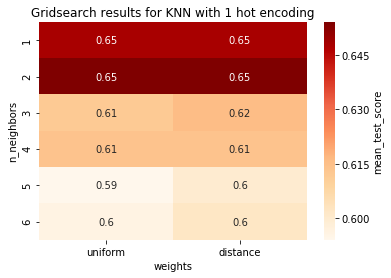

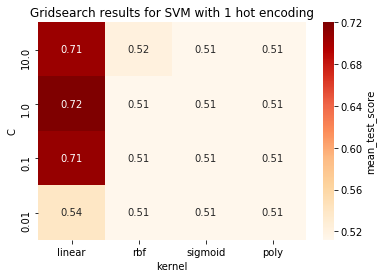

In [63]:
plot_gridsearch(knn_1h_gs, param_dict_1h_KNN, name='KNN with 1 hot encoding')
plot_gridsearch(svm_1h_gs, param_dict_1h_SVM, name='SVM with 1 hot encoding')

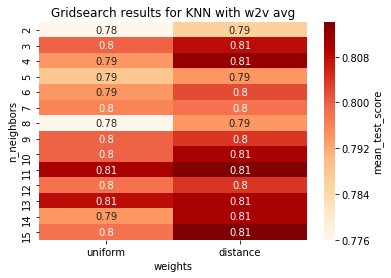

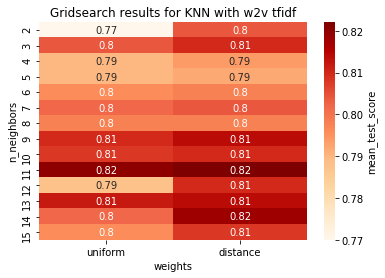

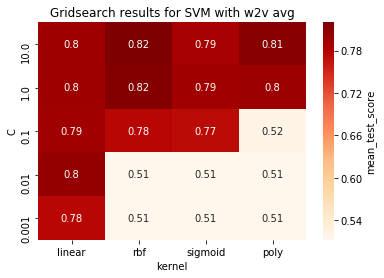

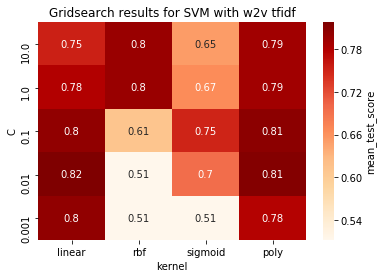

In [64]:
plot_gridsearch(knn_w2v_avg_gs, param_dict_w2v_KNN, name='KNN with w2v avg')
plot_gridsearch(knn_w2v_tfidf_gs, param_dict_w2v_KNN, name='KNN with w2v tfidf')
plot_gridsearch(svm_w2v_avg_gs, param_dict_w2v_SVM, name='SVM with w2v avg')
plot_gridsearch(svm_w2v_tfidf_gs, param_dict_w2v_SVM, name='SVM with w2v tfidf')

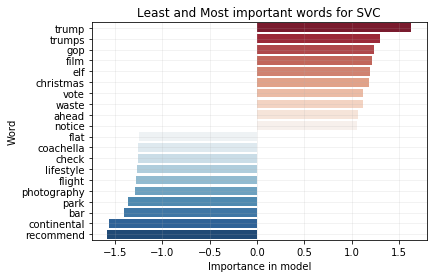

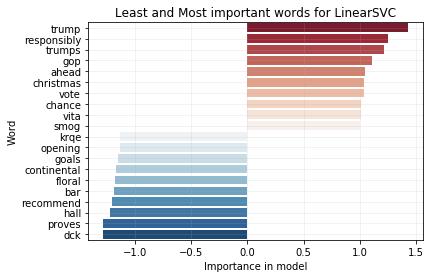

In [65]:
if best_svm_1h.kernel == 'linear':
    plot_best_words(best_svm_1h, columns_1_hot, 'SVC')
plot_best_words(best_lsvm_1h, columns_1_hot, 'LinearSVC')

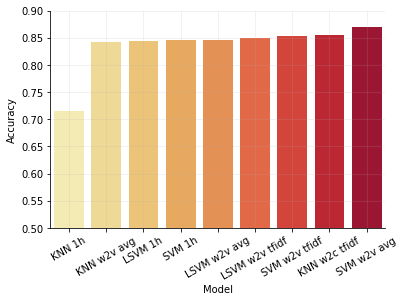

In [66]:
accs = [best_knn_1h_acc, best_svm_1h_acc, best_lsvm_1h_acc, best_knn_w2v_avg_acc, best_knn_w2v_tfidf_acc, 
        best_svm_w2v_avg_acc, best_svm_w2v_tfidf_acc, best_lsvm_w2v_avg_acc, best_lsvm_w2v_tfidf_acc]
lab = ['KNN 1h', 'SVM 1h', 'LSVM 1h', 'KNN w2v avg', 
       'KNN w2c tfidf', 'SVM w2v avg', 'SVM w2v tfidf', 
       'LSVM w2v avg', 'LSVM w2v tfidf']
df = pd.DataFrame({'Accuracy' : accs, 'Model' : lab})
df = df.sort_values('Accuracy')

ax = sns.barplot(x = 'Model', y = 'Accuracy', data = df, palette="YlOrRd")
ax.set_ylim([0.5, 0.9])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(alpha=.2)
ax.set_xticklabels(df['Model'], rotation=30)
plt.savefig('Model_accs', bbox_inches='tight', dpi=200)
plt.show()


In [67]:
throw 'a party'

SyntaxError: invalid syntax (<ipython-input-67-69847db1e52e>, line 1)